In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.distributions.mixture_rvs import mixture_rvs

# https://www.statsmodels.org/stable/examples/notebooks/generated/kernel_density.html?highlight=statsmodels%20nonparametric%20kde

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# A univariate example

np.random.seed(12345)  # Seed the random number generator for reproducible results

# bimodal distribution: a mixture of two normal distributions with locations at -1 and 1.

# Location, scale and weight for the two distributions
dist1_loc, dist1_scale, weight1 = -1, 0.5, 0.25
dist2_loc, dist2_scale, weight2 = 1, 0.5, 0.75

Nsample = 256 # sample size 16, 64, 128, 256, 1024
Nbins = int(1 + 3.322*np.log2(Nsample))

# Sample from a mixture of distributions
obs_dist = mixture_rvs(
    prob=[weight1, weight2],
    size=Nsample,                              
    dist=[stats.norm, stats.norm],
    kwargs=(
        dict(loc=dist1_loc, scale=dist1_scale),
        dict(loc=dist2_loc, scale=dist2_scale),
    ),
)

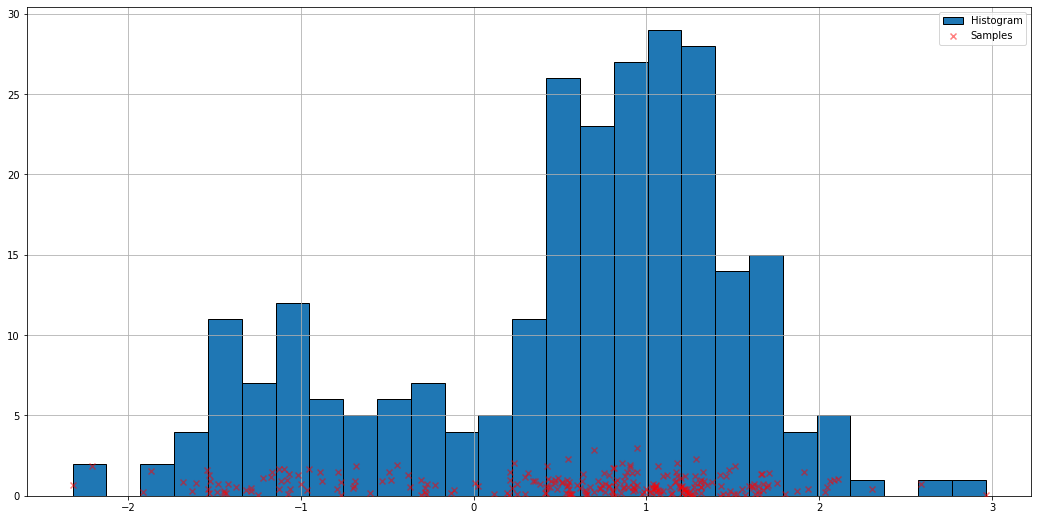

In [3]:
# histogram-based density estimation  
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(111)

# Scatter plot of data samples and histogram
ax.scatter(
    obs_dist,
    np.abs(np.random.randn(obs_dist.size)),
    zorder=15,
    color="red",
    marker="x",
    alpha=0.5,
    label="Samples",
)
lines = ax.hist(obs_dist, bins=Nbins, edgecolor="k", label="Histogram")

ax.legend(loc="best")
ax.grid(True, zorder=-5)

In [4]:
# Fitting with the default arguments
kde = sm.nonparametric.KDEUnivariate(obs_dist)
kde.fit()  # Estimate the densities

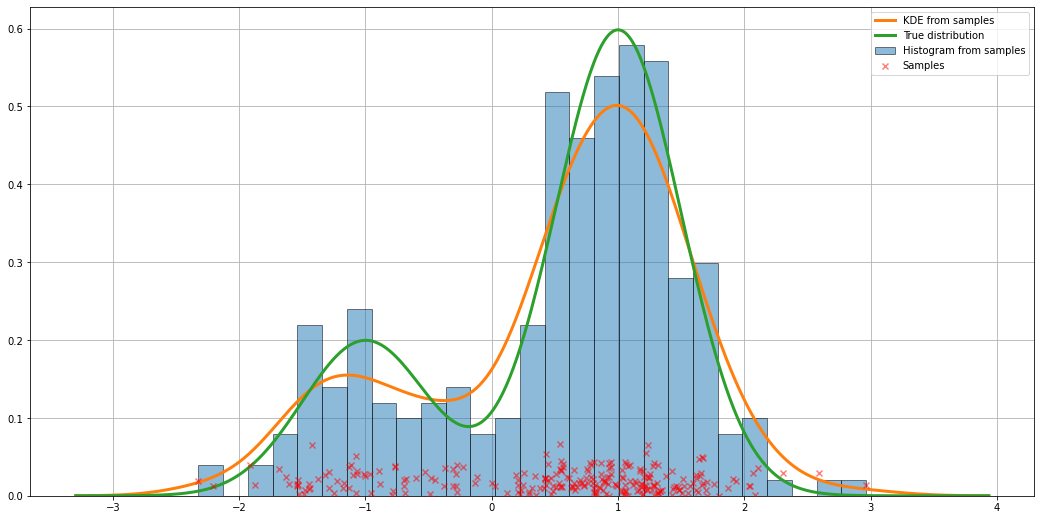

In [5]:
# plotting of  fitting figure, as well as the true distribution

fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(111)
 

# Plot the histrogram
ax.hist(
    obs_dist,
    bins=Nbins,
    density=True,
    label="Histogram from samples",
    zorder=5,
    edgecolor="k",
    alpha=0.5,
)

# Plot the KDE as fitted using the default arguments
ax.plot(kde.support, kde.density, lw=3, label="KDE from samples", zorder=10)

# Plot the true distribution
true_values = (
    stats.norm.pdf(loc=dist1_loc, scale=dist1_scale, x=kde.support) * weight1
    + stats.norm.pdf(loc=dist2_loc, scale=dist2_scale, x=kde.support) * weight2
)
ax.plot(kde.support, true_values, lw=3, label="True distribution", zorder=15)

# Plot the samples
ax.scatter(
    obs_dist,
    np.abs(np.random.randn(obs_dist.size)) / 40,
    marker="x",
    color="red",
    zorder=20,
    label="Samples",
    alpha=0.5,
)

ax.legend(loc="best")
ax.grid(True, zorder=-5)

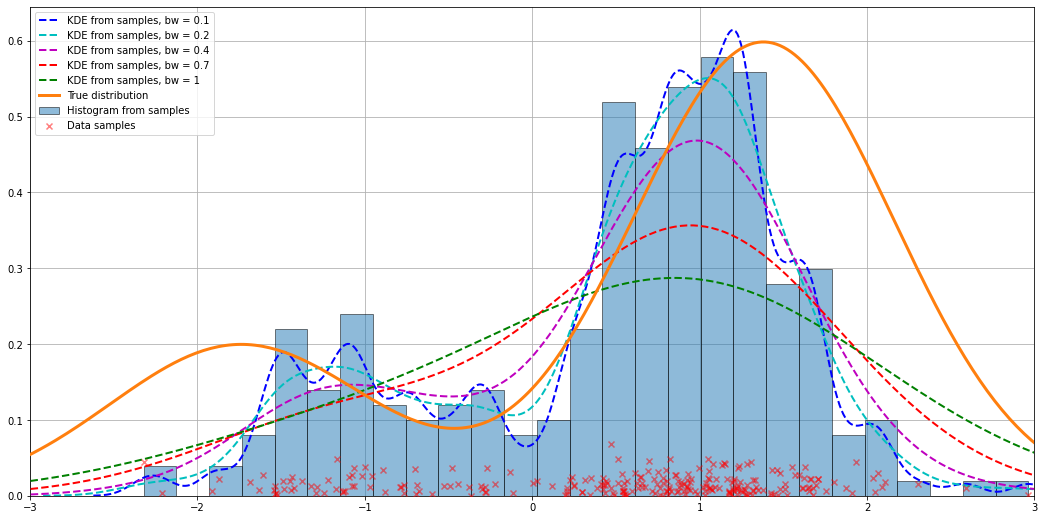

In [6]:
# Varying the bandwidth using the bw argument
# a bandwidth of bw=0.2 seems to fit the data well.

fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(111)

# Plot the histrogram
ax.hist(
    obs_dist,
    bins=Nbins,
    label="Histogram from samples",
    zorder=5,
    edgecolor="k",
    density=True,
    alpha=0.5,
)

# Plot the KDE for various bandwidths
for bandwidth in [0.1, 0.2, 0.4, 0.7, 1]:
    if bandwidth == 0.1:
      coloi = "b"  
    if bandwidth == 0.2:
      coloi = "c"  
    if bandwidth == 0.4:
      coloi = "m"  
    if bandwidth == 0.7:
      coloi = "r"
    if bandwidth == 1:
      coloi = "g"
    kde.fit(bw=bandwidth)  # Estimate the densities
    ax.plot(
        kde.support,
        kde.density,
        "--",
        lw=2,
        color=coloi,
        zorder=10,
        label="KDE from samples, bw = {}".format(round(bandwidth, 2)),
    )

# Plot the true distribution
ax.plot(kde.support, true_values, lw=3, label="True distribution", zorder=15)

# Plot the samples
ax.scatter(
    obs_dist,
    np.abs(np.random.randn(obs_dist.size)) / 50,
    marker="x",
    color="red",
    zorder=20,
    label="Data samples",
    alpha=0.5,
)

ax.legend(loc="best")
ax.set_xlim([-3, 3])
ax.grid(True, zorder=-5)

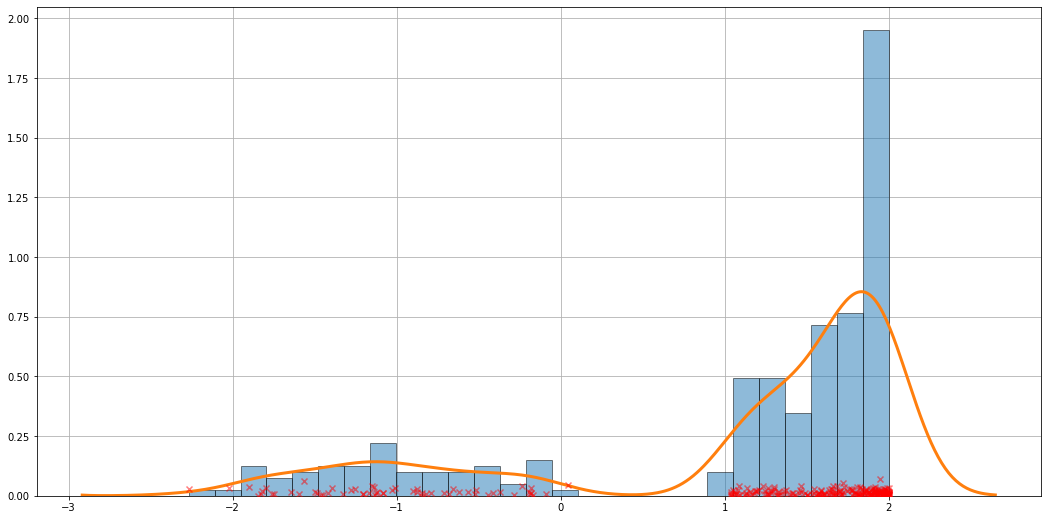

In [7]:
# a more difficult case

Nsample = 256 # sample size 16, 64, 128, 256, 1024
Nbins = int(1 + 3.322*np.log2(Nsample))

obs_dist = mixture_rvs(
    [0.25, 0.75],
    size=Nsample,
    dist=[stats.norm, stats.beta],
    kwargs=(dict(loc=-1, scale=0.5), dict(loc=1, scale=1, args=(1, 0.5))),
)

kde = sm.nonparametric.KDEUnivariate(obs_dist)
kde.fit()

fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(111)
ax.hist(obs_dist, bins=Nbins, density=True, edgecolor="k", zorder=4, alpha=0.5)
ax.plot(kde.support, kde.density, lw=3, zorder=7)
# Plot the samples
ax.scatter(
    obs_dist,
    np.abs(np.random.randn(obs_dist.size)) / 50,
    marker="x",
    color="red",
    zorder=20,
    label="Data samples",
    alpha=0.5,
)
ax.grid(True, zorder=-5)

In [8]:
# Entropy estimate
kde = sm.nonparametric.KDEUnivariate(obs_dist)
kde.fit(gridsize=2 ** 10)
kde.entropy

1.0516297058371877

In [9]:
# Comparing kernel functions
from statsmodels.nonparametric.kde import kernel_switch

list(kernel_switch.keys())

['gau', 'epa', 'uni', 'tri', 'biw', 'triw', 'cos', 'cos2']

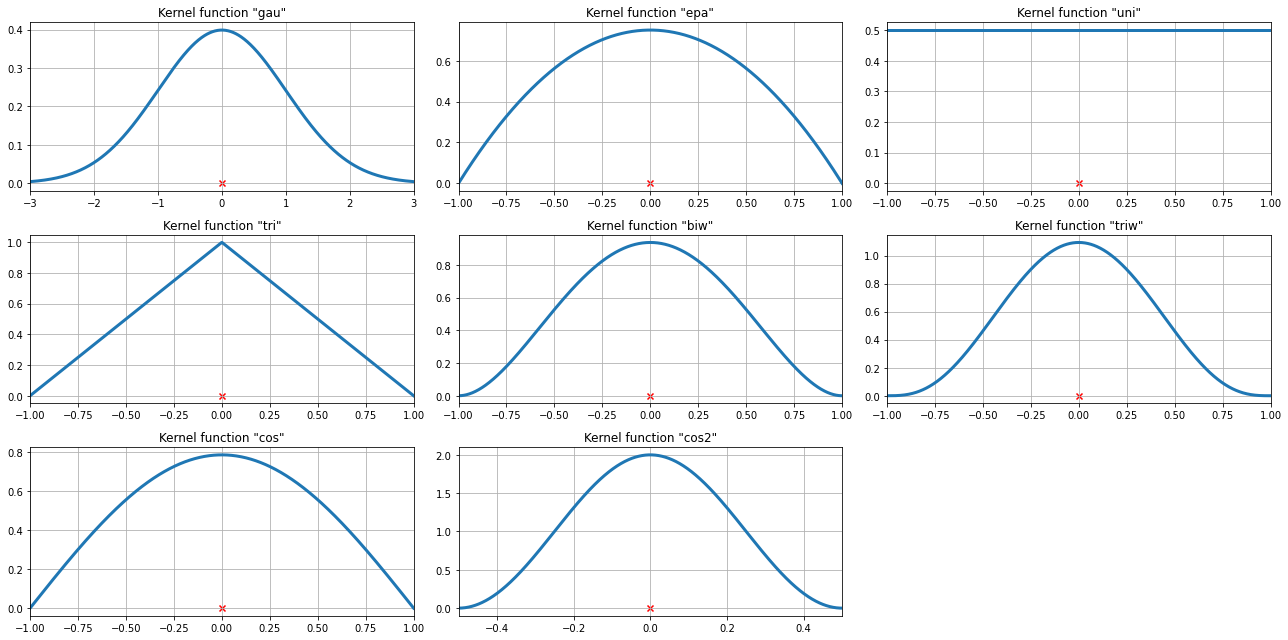

In [10]:
# Create a figure
fig = plt.figure(figsize=(18, 9))

# Enumerate every option for the kernel
for i, (ker_name, ker_class) in enumerate(kernel_switch.items()):

    # Initialize the kernel object
    kernel = ker_class()

    # Sample from the domain
    domain = kernel.domain or [-3, 3]
    x_vals = np.linspace(*domain, num=2 ** 10)
    y_vals = kernel(x_vals)

    # Create a subplot, set the title
    ax = fig.add_subplot(3, 3, i + 1)
    ax.set_title('Kernel function "{}"'.format(ker_name))
    ax.plot(x_vals, y_vals, lw=3, label="{}".format(ker_name))
    ax.scatter([0], [0], marker="x", color="red")
    plt.grid(True, zorder=-5)
    ax.set_xlim(domain)

plt.tight_layout()

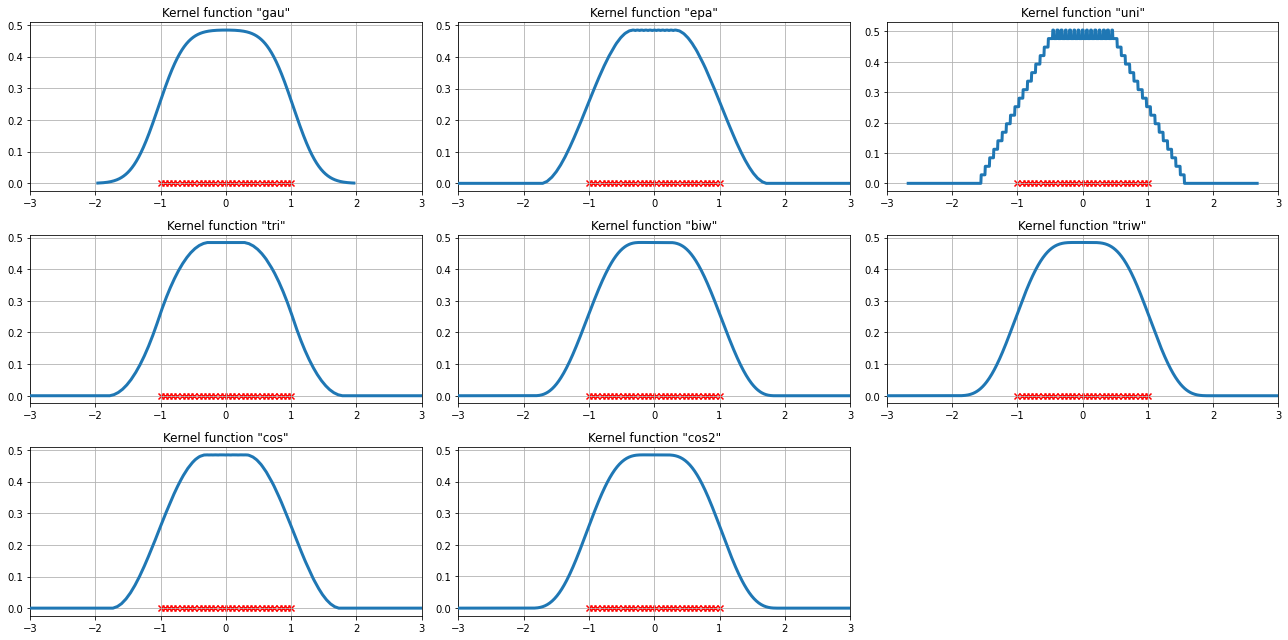

In [11]:
# kernel density estimate   fitting to M equally spaced data points.

# Create three equidistant points
M = 32                              # 3, 6,  32
data = np.linspace(-1, 1, M)
kde = sm.nonparametric.KDEUnivariate(data)

# Create a figure
fig = plt.figure(figsize=(18, 9))

# Enumerate every option for the kernel
for i, kernel in enumerate(kernel_switch.keys()):

    # Create a subplot, set the title
    ax = fig.add_subplot(3, 3, i + 1)
    ax.set_title('Kernel function "{}"'.format(kernel))

    # Fit the model (estimate densities)
    kde.fit(kernel=kernel, fft=False, gridsize=2 ** 10)

    # Create the plot
    ax.plot(kde.support, kde.density, lw=3, label="KDE from samples", zorder=10)
    ax.scatter(data, np.zeros_like(data), marker="x", color="red")
    plt.grid(True, zorder=-5)
    ax.set_xlim([-3, 3])

plt.tight_layout()